# POC Store Sales

### Philippe de Saint Chamas - Emma Demarecaux -  Charles Desaleux - Gwendal Hengoat -  Benjamin Wallyn

### M2 Data Science - Machine Learning Business Case - 19 avril 2020

The goal of the project is to predict sales up to 6 weeks in advance of a company. It would help the company adapt their offer, run their stocks, identify their most profitable stores.

We train learning algorithm which will use their data from previous years to understand the evolution of the market and temporal fluctuations based on the characteristics of stores

The dataset is composed of information about stores like number of customers, sales, promotions, .etc. It is divided into 3 different csv files: 
* store.csv : opening date, distance of competition, etc.
* train.csv : the training file on which we will learn our model. Each row is linked to a store and a date, with the number of customers, sales, whether the store was opened etc.
* test.csv : the test file which are the next 6 weeks we have to predict

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import operator
import datetime as dt

from sklearn.model_selection import train_test_split
from preprocessing import preprocessing, merge_data
from model import rmse, mae, rmse_XGBoost, create_feature_map

import warnings
warnings.filterwarnings('ignore')

## Variables

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [2]:
data_path = 'data/raw/'
results_path = ''
# Load datasets
store = pd.read_csv(data_path + 'store.csv')
train = pd.read_csv(data_path + 'train.csv', low_memory=False)
test = pd.read_csv(data_path + 'test.csv')

## Exploration

### Store data

In [3]:
store.head(3)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [4]:
store.shape

(1115, 10)

In [5]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [6]:
# Proportion of NaN among the features
store.isna().sum() / store.shape[0]

Store                        0.000000
StoreType                    0.000000
Assortment                   0.000000
CompetitionDistance          0.002691
CompetitionOpenSinceMonth    0.317489
CompetitionOpenSinceYear     0.317489
Promo2                       0.000000
Promo2SinceWeek              0.487892
Promo2SinceYear              0.487892
PromoInterval                0.487892
dtype: float64

In [7]:
store.nunique()

Store                        1115
StoreType                       4
Assortment                      3
CompetitionDistance           654
CompetitionOpenSinceMonth      12
CompetitionOpenSinceYear       23
Promo2                          2
Promo2SinceWeek                24
Promo2SinceYear                 7
PromoInterval                   3
dtype: int64

This dataset contains $1115$ rows, one for each store. Therefore, the `Store` column is a primary key of this table.

In [8]:
store.describe(include='all')

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115.00000,1115,1115,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000,571
unique,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,a,a,NaN,NaN,NaN,NaN,NaN,NaN,"Jan,Apr,Jul,Oct"
freq,NaN,602,593,NaN,NaN,NaN,NaN,NaN,NaN,335
mean,558.00000,NaN,NaN,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573,NaN
std,322.01708,NaN,NaN,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935,NaN
min,1.00000,NaN,NaN,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000,NaN
25%,279.50000,NaN,NaN,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000,NaN
50%,558.00000,NaN,NaN,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000,NaN
75%,836.50000,NaN,NaN,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000,NaN


### Sales data

In [9]:
train.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


In [10]:
train.shape

(1017209, 9)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [12]:
train.isna().sum() / train.shape[0]

Store            0.0
DayOfWeek        0.0
Date             0.0
Sales            0.0
Customers        0.0
Open             0.0
Promo            0.0
StateHoliday     0.0
SchoolHoliday    0.0
dtype: float64

There are no null values in the train set.

In [13]:
train.nunique()

Store             1115
DayOfWeek            7
Date               942
Sales            21734
Customers         4086
Open                 2
Promo                2
StateHoliday         4
SchoolHoliday        2
dtype: int64

In [14]:
train.describe(include='all')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1017209,1.017209e+06
unique,NaN,NaN,942,NaN,NaN,NaN,NaN,4,NaN
top,NaN,NaN,2013-08-09,NaN,NaN,NaN,NaN,0,NaN
freq,NaN,NaN,1115,NaN,NaN,NaN,NaN,986159,NaN
mean,5.584297e+02,3.998341e+00,NaN,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,NaN,1.786467e-01
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,NaN,3.830564e-01
min,1.000000e+00,1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00
25%,2.800000e+02,2.000000e+00,NaN,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00
50%,5.580000e+02,4.000000e+00,NaN,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00
75%,8.380000e+02,6.000000e+00,NaN,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,NaN,0.000000e+00


From this table, we can see that most of the observations have `Open = 1` and `StateHoliday = 0`.

In [15]:
test.head(3)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0


In [16]:
test.shape

(41088, 8)

In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [18]:
test.isna().sum() / test.shape[0]

Id               0.000000
Store            0.000000
DayOfWeek        0.000000
Date             0.000000
Open             0.000268
Promo            0.000000
StateHoliday     0.000000
SchoolHoliday    0.000000
dtype: float64

There is less than $0.03$% of null values in the test set for the `Open` feature.

In [19]:
test.nunique()

Id               41088
Store              856
DayOfWeek            7
Date                48
Open                 2
Promo                2
StateHoliday         2
SchoolHoliday        2
dtype: int64

In [20]:
test.describe(include='all')

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088.000000,41088.000000,41088.000000,41088,41077.000000,41088.000000,41088,41088.000000
unique,NaN,NaN,NaN,48,NaN,NaN,2,NaN
top,NaN,NaN,NaN,2015-08-01,NaN,NaN,0,NaN
freq,NaN,NaN,NaN,856,NaN,NaN,40908,NaN
mean,20544.500000,555.899533,3.979167,NaN,0.854322,0.395833,NaN,0.443487
std,11861.228267,320.274496,2.015481,NaN,0.352787,0.489035,NaN,0.496802
min,1.000000,1.000000,1.000000,NaN,0.000000,0.000000,NaN,0.000000
25%,10272.750000,279.750000,2.000000,NaN,1.000000,0.000000,NaN,0.000000
50%,20544.500000,553.500000,4.000000,NaN,1.000000,0.000000,NaN,0.000000
75%,30816.250000,832.250000,6.000000,NaN,1.000000,1.000000,NaN,1.000000


## Analysis

### `Open`

Let us figure out the days of the week Rossemann stores are open.

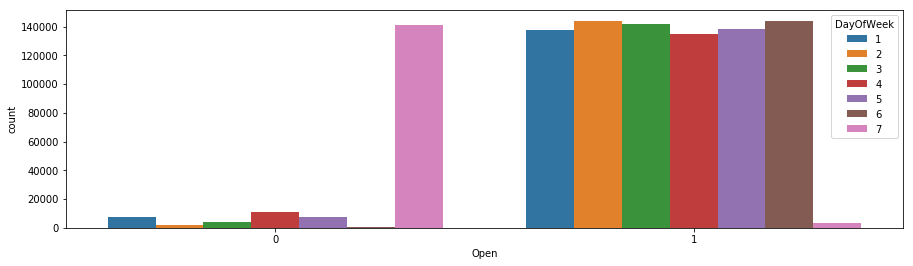

In [21]:
# Plot DayOfWeek for Open
fig, axis = plt.subplots(1, 1, figsize=(15,4))
sns.countplot(x='Open', hue='DayOfWeek', data=train, ax=axis)

Stores appear to be mostly closed on Sundays and open on other days of the week.

Let us check if there are any sales when the stores are not open.

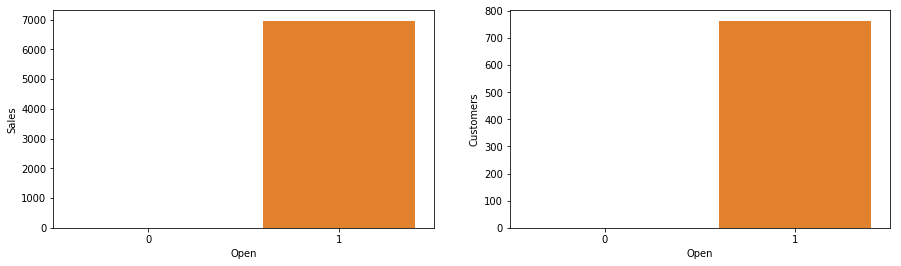

In [22]:
# Plot Sales & Customers for Open
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
sns.barplot(x='Open', y='Sales', data=train, ax=axis1)
sns.barplot(x='Open', y='Customers', data=train, ax=axis2)

A closed store generates $0$ sale. Therefore, we can set the sales amount to $0$ every time a shop is not open. Then, we will focus on predicting the sales for open stores.

### `Store`
Let us look at how the sales vary across stores. To do that we calculate the average sales for each store to have a better idea on how the store differ in size.

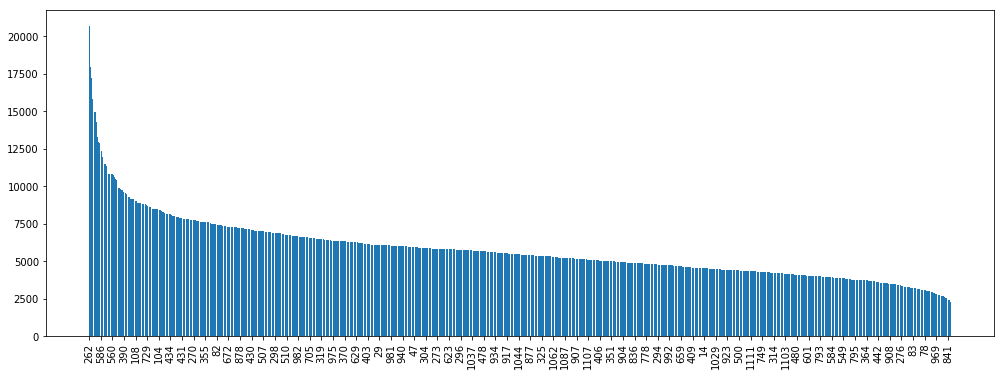

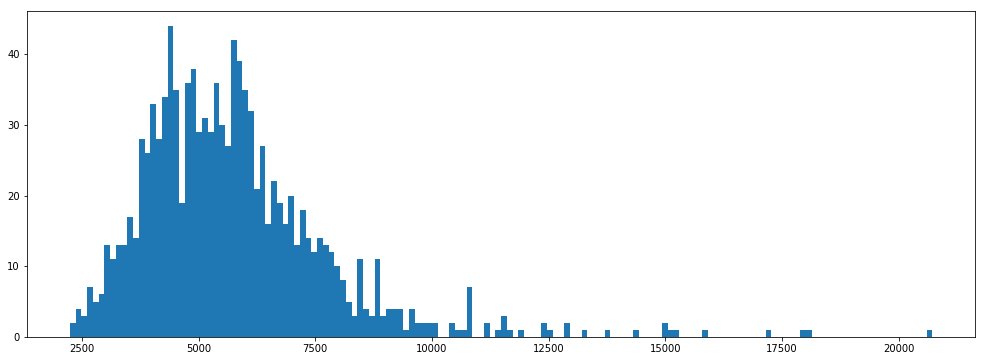

In [23]:
# Group by Store and get average Sales and Customers
average_sales = train.groupby('Store')['Sales'].mean().sort_values(ascending=False).reset_index(drop=False)
average_customers = train.groupby('Store')['Customers'].mean().sort_values(ascending=False).reset_index(drop=False)

# Plot average Sales and Customers over time (Year-Month)
fig, axis = plt.subplots(1, 1, figsize=(17, 6))
plt.bar(range(len(average_sales)), average_sales.Sales)
axis.set_xticks(range(0, len(average_sales), 15))
xlabels = axis.set_xticklabels([j for (i,j) in enumerate(average_sales.Store) if i%15==0], rotation=90)

# Histogram
fig, axis = plt.subplots(1, 1, figsize=(17, 6))
plt.hist(average_sales.Sales, bins=150)
plt.show()

A few stores have generated many sales compared to the majority.

### `Date`

In [24]:
# Create Year-Month column from Date
train['YearMonth'] = train['Date'].apply(lambda x: (str(x)[:7]))
# Convert Date to datetime
train['Date'] = pd.to_datetime(train['Date'], format='%Y-%m-%d')
# Extract Year
train['Year'] = train.Date.dt.year
# Extract Month
train['Month'] = train.Date.dt.month
# Extract Day
train['Day'] = train.Date.dt.day
# Extract WeekOfYear
train['WeekOfYear'] = train.Date.dt.weekofyear

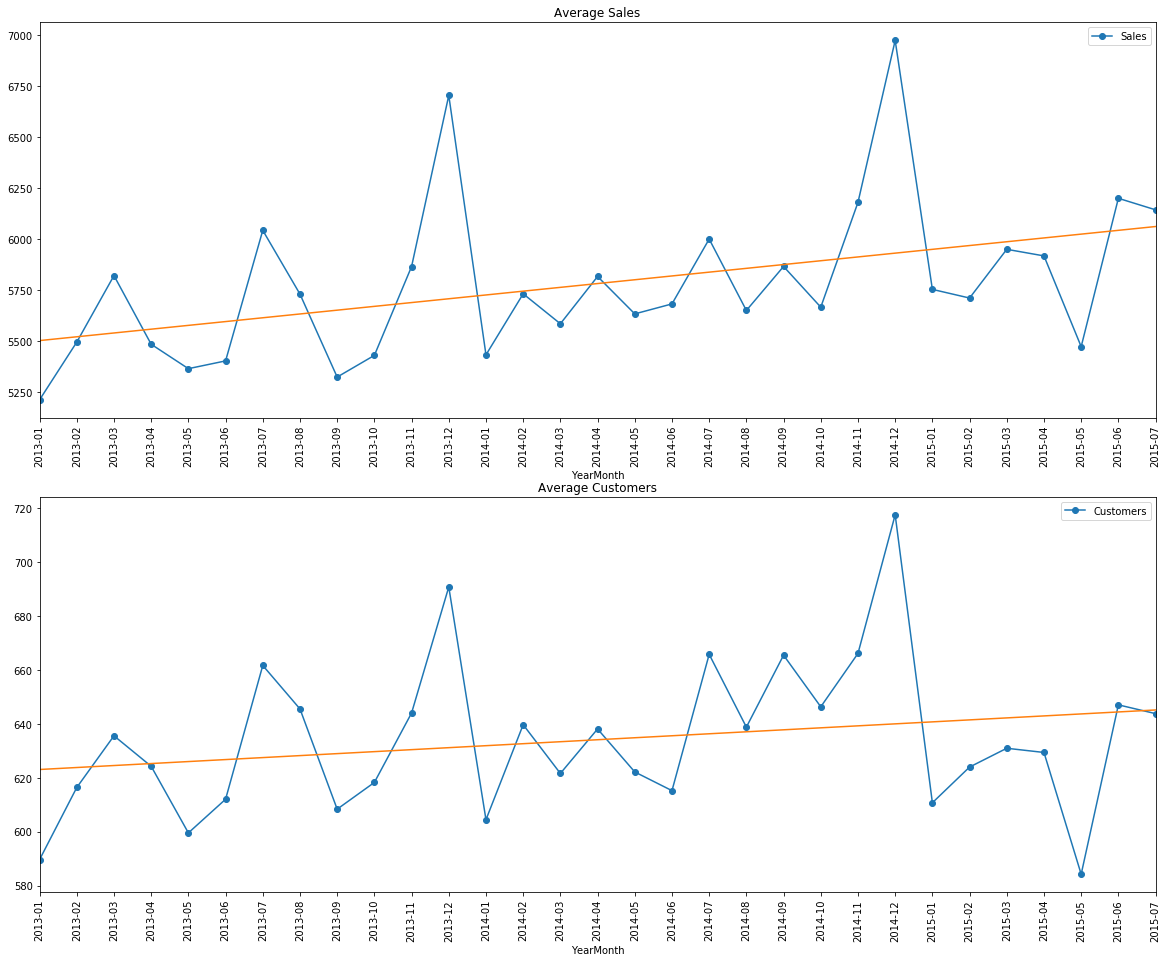

In [25]:
# Group by (Year-Month) and get average Sales and Customers
average_sales = train.groupby('YearMonth')['Sales'].mean()
average_customers = train.groupby('YearMonth')['Customers'].mean()

# Linear regression
dates = range(len(train.YearMonth.unique()))
m1, b1 = np.polyfit(dates, average_sales, 1)
m2, b2 = np.polyfit(dates, average_customers, 1)

# Plot average Sales and Customers over time (Year-Month)
fig, (axis1, axis2) = plt.subplots(2, 1, figsize=(20, 16))
ax = average_sales.plot(legend=True, ax=axis1, marker='o', title='Average Sales')
ax.plot(m1*dates + b1)
ax.set_xticks(range(len(average_sales)))
xlabels = ax.set_xticklabels(average_sales.index.tolist(), rotation=90)
ax = average_customers.plot(legend=True, ax=axis2, marker='o', title='Average Customers')
ax.plot(m2*dates + b2)
ax.set_xticks(range(len(average_customers)))
xlabels = ax.set_xticklabels(average_customers.index.tolist(), rotation=90)

`Customers` and `Sales` are very correlated variables. Let us take a closer look to correlations.

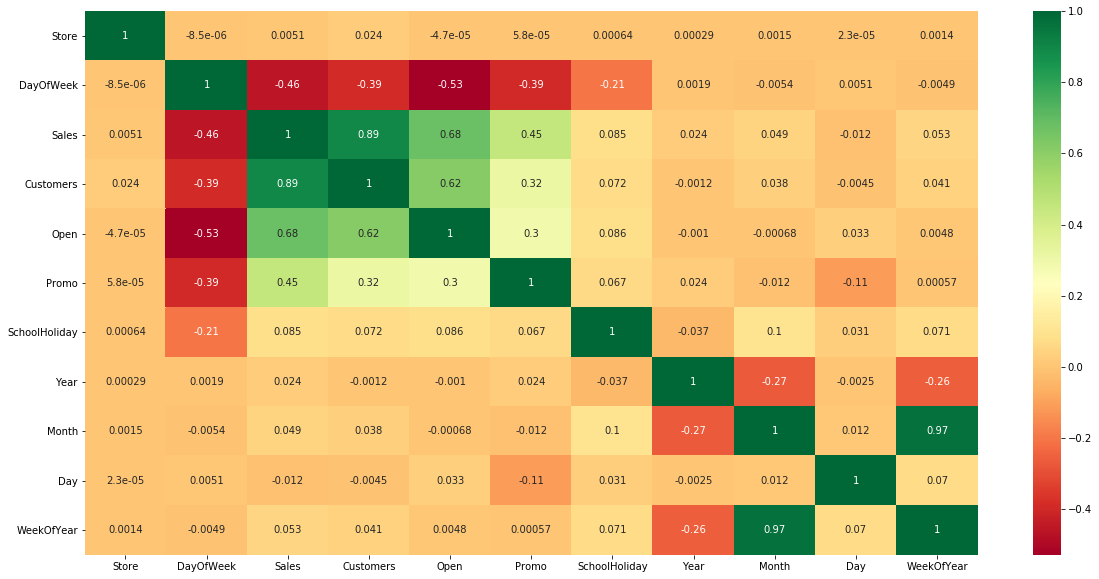

In [26]:
# Correlations
plt.figure(figsize=(20, 10))
sns.heatmap(train.corr(), annot=True, cmap="RdYlGn")

We can see that the variable most correlated with `Sales` is `Customers`. Then, we can find `Open`, `DayofWeek` and `Promo`.

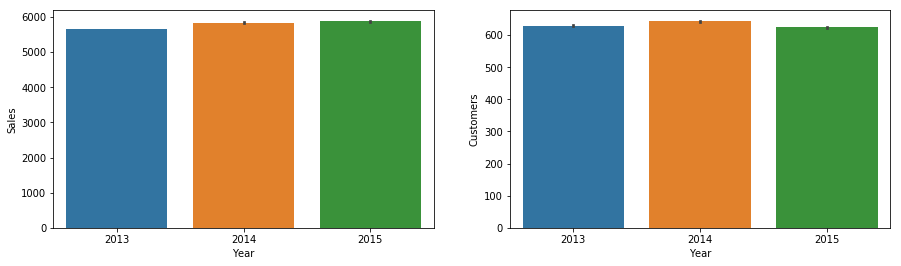

In [27]:
# Plot average Sales & Customers for every year
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x='Year', y='Sales', data=train, ax=axis1)
sns.barplot(x='Year', y='Customers', data=train, ax=axis2)

The sales do not appear to change over the years.

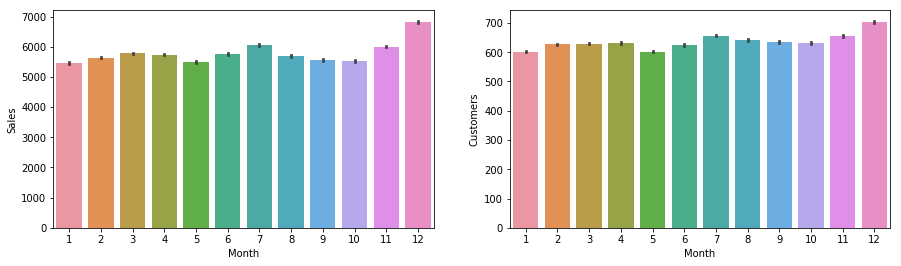

In [28]:
# Plot average Sales & Customers for every month
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x='Month', y='Sales', data=train, ax=axis1)
sns.barplot(x='Month', y='Customers', data=train, ax=axis2)

As expected, there seems to be more sales in December, close to Christmas.

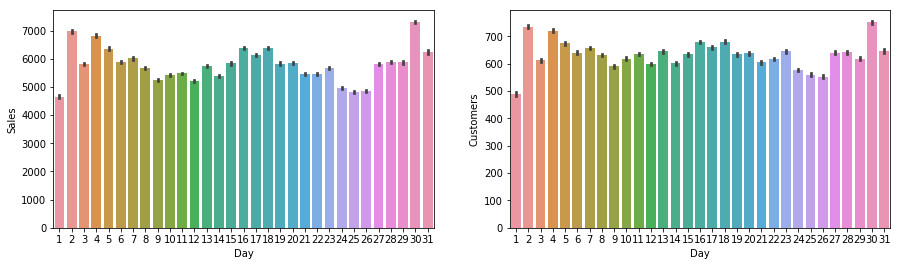

In [29]:
# Plot average Sales & Customers for every day of a month
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x='Day', y='Sales', data=train, ax=axis1)
sns.barplot(x='Day', y='Customers', data=train, ax=axis2)

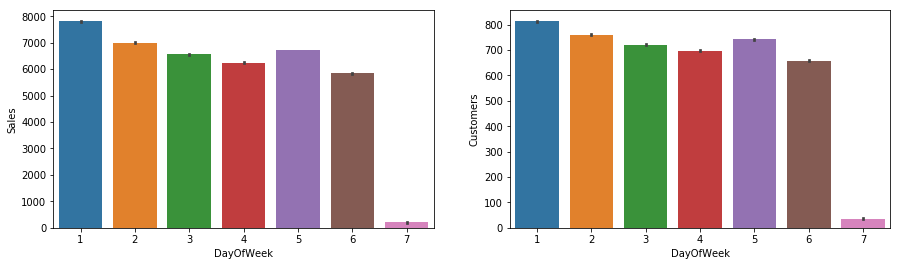

In [30]:
# Plot average Sales & Customers for every DayOfWeek
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x='DayOfWeek', y='Sales', data=train, ax=axis1)
sns.barplot(x='DayOfWeek', y='Customers', data=train, ax=axis2)

As stores are often closed on Sunday, there are almost no sales. We saw that `Sales` and `DayOfWeek` are correlated, and indeed, there are more sales on Mondays and Fridays and less sales on Thursdays.

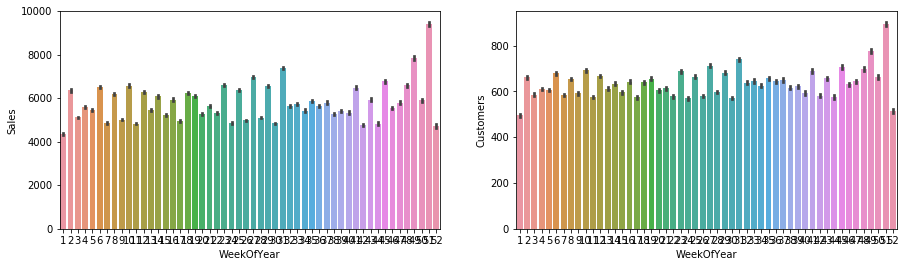

In [31]:
# Plot average Sales & Customers for every WeekOfYear
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x='WeekOfYear', y='Sales', data=train, ax=axis1)
sns.barplot(x='WeekOfYear', y='Customers', data=train, ax=axis2)

Again, we can see that during the week before Christmas, there are more sales than usual.

### `Promo`

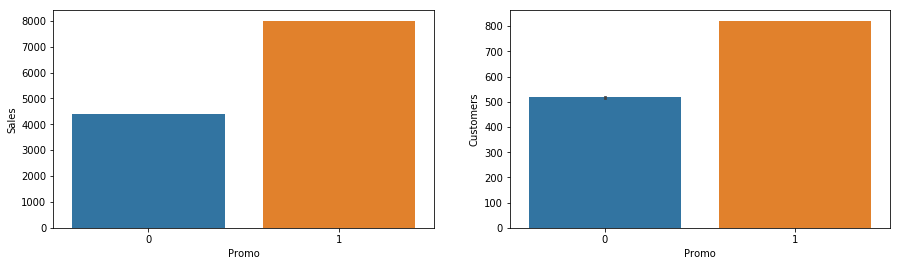

In [32]:
# Plot average Sales & Customers with/without promo
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x='Promo', y='Sales', data=train, ax=axis1)
sns.barplot(x='Promo', y='Customers', data=train, ax=axis2)

We saw that `Sales` and `Promo` are correlated, and indeed, there are way more sales when there is a promo than usual.

### `StateHoliday`

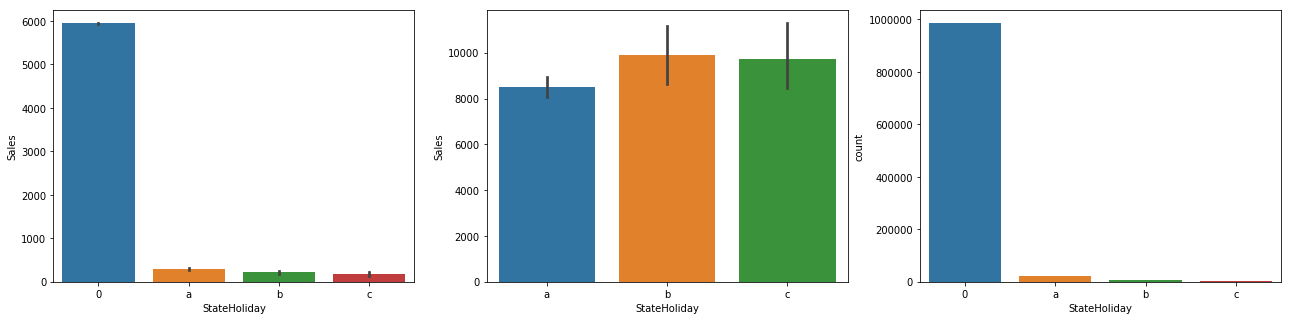

In [33]:
# StateHoliday column has values 0 & '0', so we need to merge values with 0 to '0'
train.loc[train['StateHoliday'] == 0, 'StateHoliday'] = '0'

# Plot
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(22, 5))
sns.barplot(x='StateHoliday', y='Sales', data=train, ax=axis1)
mask = (train['StateHoliday'] != '0') & (train['Sales'] > 0)
sns.barplot(x='StateHoliday', y='Sales', data=train[mask], ax=axis2)
sns.countplot(x='StateHoliday', data=train, ax=axis3)

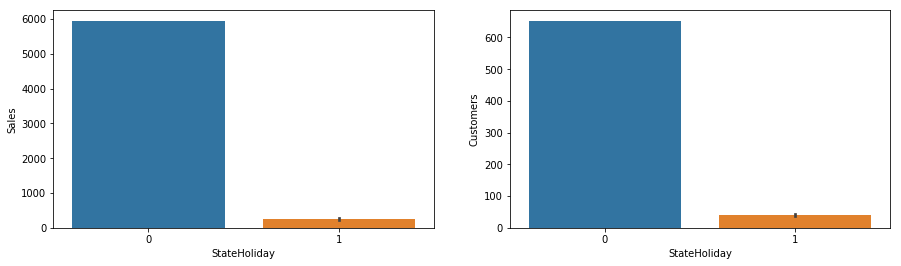

In [34]:
# Assign 1 to every StateHolidays and 0 otherwise
train['StateHoliday'] = train['StateHoliday'].map({0: 0, '0': 0, 'a': 1, 'b': 1, 'c': 1})

# Plot
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 4))
sns.barplot(x='StateHoliday', y='Sales', data=train, ax=axis1)
sns.barplot(x='StateHoliday', y='Customers', data=train, ax=axis2)

### `SchoolHoliday`

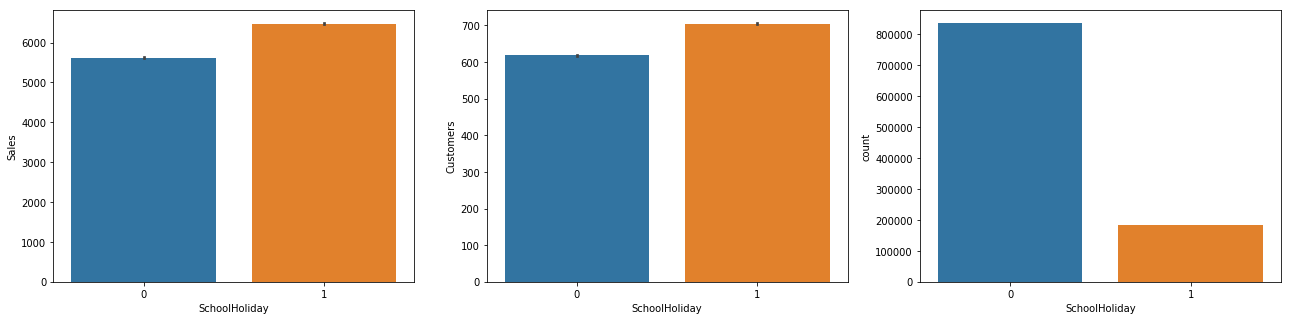

In [35]:
# Plot
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(22, 5))
sns.barplot(x='SchoolHoliday', y='Sales', data=train, ax=axis1)
sns.barplot(x='SchoolHoliday', y='Customers', data=train, ax=axis2)
sns.countplot(x='SchoolHoliday', data=train, ax=axis3)

There is way more sales during a school holiday than usual.

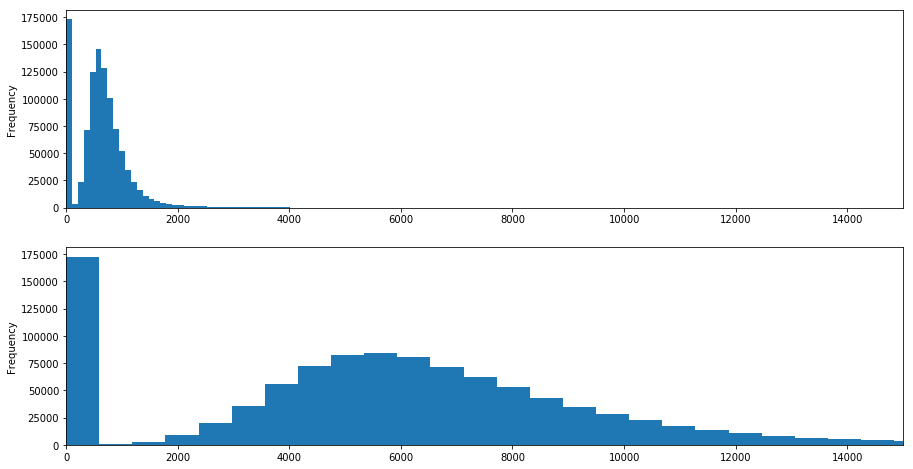

In [36]:
# Plot Sales and Customers values: notice that values with 0 is mostly because the store was closed
fig, (axis1, axis2) = plt.subplots(2, 1, figsize=(15, 8))
train['Customers'].plot(kind='hist', bins=70, xlim=(0,15000), ax=axis1)
train['Sales'].plot(kind='hist', bins=70, xlim=(0,15000), ax=axis2)

### Store data

In [37]:
# Merge store with average Sales & Customers per store
average_sales_customers = train.groupby('Store')[['Sales', 'Customers']].mean()
sales_customers_df = pd.DataFrame(data = {'Store': average_sales_customers.index,
                                          'Sales': average_sales_customers['Sales'].values, 
                                          'Customers': average_sales_customers['Customers'].values}, 
                                  columns=['Store', 'Sales', 'Customers'])
store_df = pd.merge(sales_customers_df, store, on='Store')
store_df.head(3)

,Store,Sales,Customers,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,3945.704883,467.646497,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,4122.991507,486.045648,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5741.253715,620.286624,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


#### `StoreType`

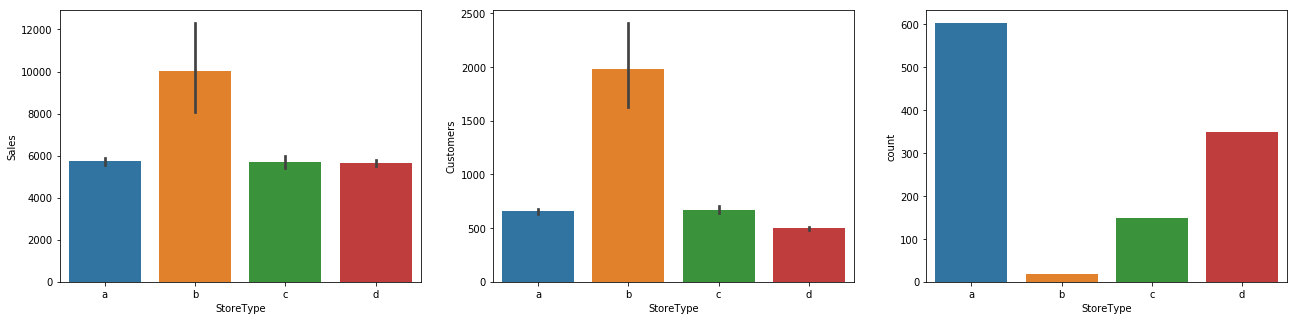

In [38]:
# Plot StoreType and StoreType vs average Sales and Customers
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(22, 5))
sns.barplot(x='StoreType', y='Sales', data=store_df, order=['a','b','c', 'd'], ax=axis1)
sns.barplot(x='StoreType', y='Customers', data=store_df, order=['a','b','c', 'd'], ax=axis2)
sns.countplot(x='StoreType', data=store_df, order=['a','b','c', 'd'], ax=axis3)

#### `Assortment`

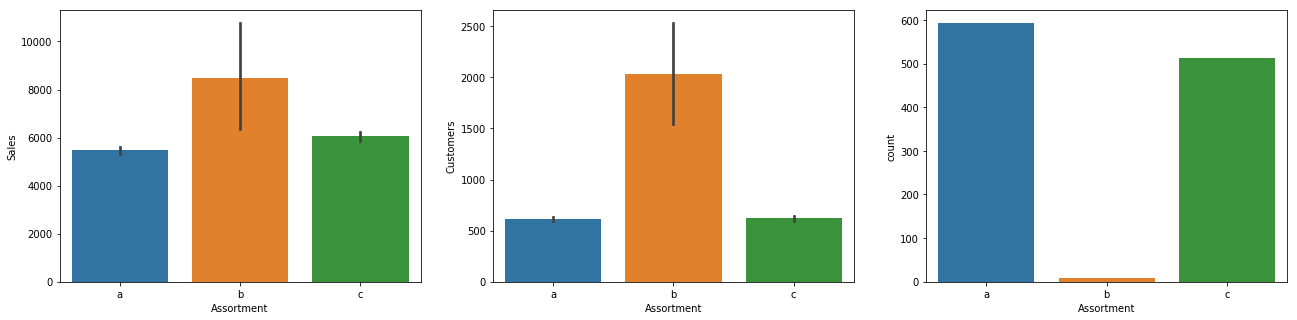

In [39]:
# Plot Assortment and Assortment vs average Sales and Customers
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(22, 5))
sns.barplot(x='Assortment', y='Sales', data=store_df, order=['a','b','c'], ax=axis1)
sns.barplot(x='Assortment', y='Customers', data=store_df, order=['a','b','c'], ax=axis2)
sns.countplot(x='Assortment', data=store_df, order=['a','b','c'], ax=axis3)

#### `Promo2`

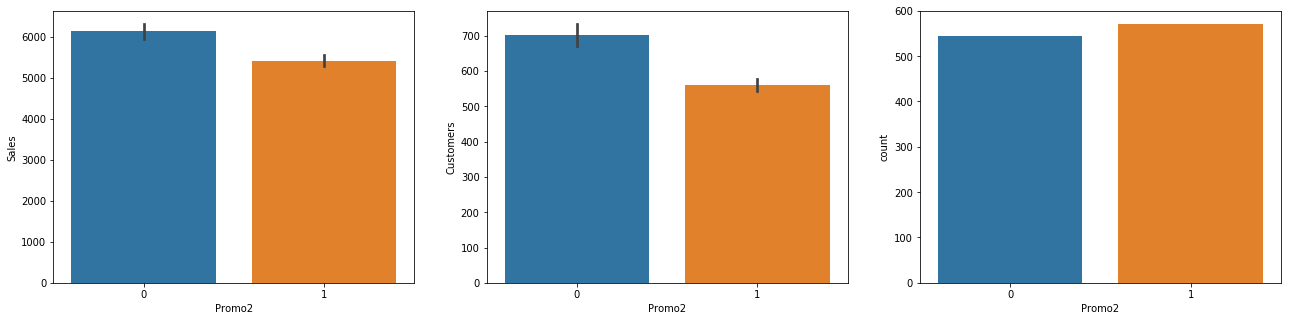

In [40]:
# Plot Promo2 and Promo2 vs average Sales and Customers
fig, (axis1, axis2, axis3) = plt.subplots(1, 3, figsize=(22, 5))
sns.barplot(x='Promo2', y='Sales', data=store_df, ax=axis1)
sns.barplot(x='Promo2', y='Customers', data=store_df, ax=axis2)
sns.countplot(x='Promo2', data=store_df, ax=axis3)

#### `CompetitionDistance`

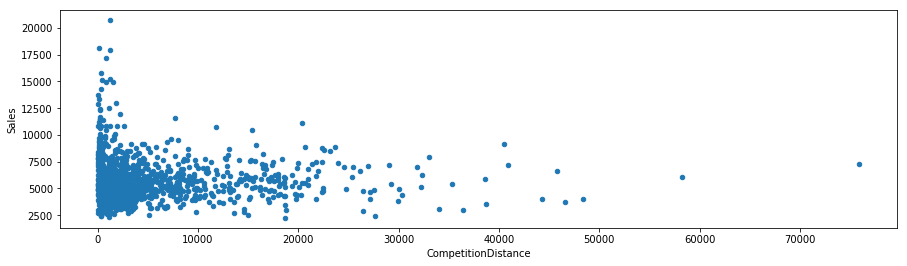

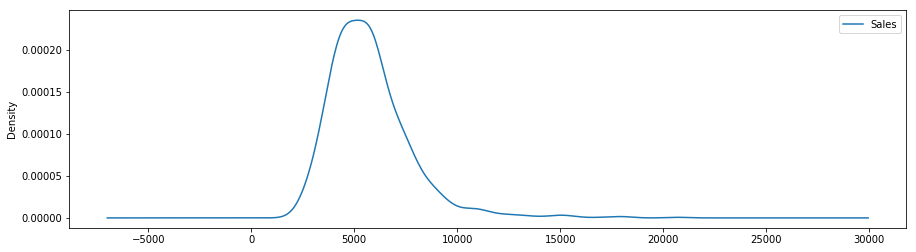

In [41]:
# CompetitionDistance fill NaN values
store_df['CompetitionDistance'].fillna(store_df['CompetitionDistance'].median(), inplace=True)

# Plot CompetitionDistance Vs Sales
store_df.plot(kind='scatter', x='CompetitionDistance', y='Sales', figsize=(15, 4))
store_df.plot(kind='kde', x='CompetitionDistance', y='Sales', figsize=(15, 4))

#### `CompetitionOpenSinceYear` and `CompetitionOpenSinceMonth`

In [42]:
store_df[(store_df['CompetitionOpenSinceYear']==2014) & (store_df['CompetitionOpenSinceMonth']==2)].head(3)

,Store,Sales,Customers,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
29,30,4367.352442,641.006369,a,a,40.0,2.0,2014.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
44,45,4422.991507,343.505308,d,a,9710.0,2.0,2014.0,0,NaN,NaN,NaN
267,268,4062.462845,497.722930,a,a,4520.0,2.0,2014.0,0,NaN,NaN,NaN


In [43]:
store_df[(store_df['CompetitionOpenSinceYear']==2013) & (store_df['CompetitionOpenSinceMonth']==12)].head(3)

,Store,Sales,Customers,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
5,6,4562.375796,525.990446,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
74,75,5013.150743,534.435244,d,c,22440.0,12.0,2013.0,0,NaN,NaN,NaN
580,581,4410.792994,485.962845,a,a,7250.0,12.0,2013.0,0,NaN,NaN,NaN


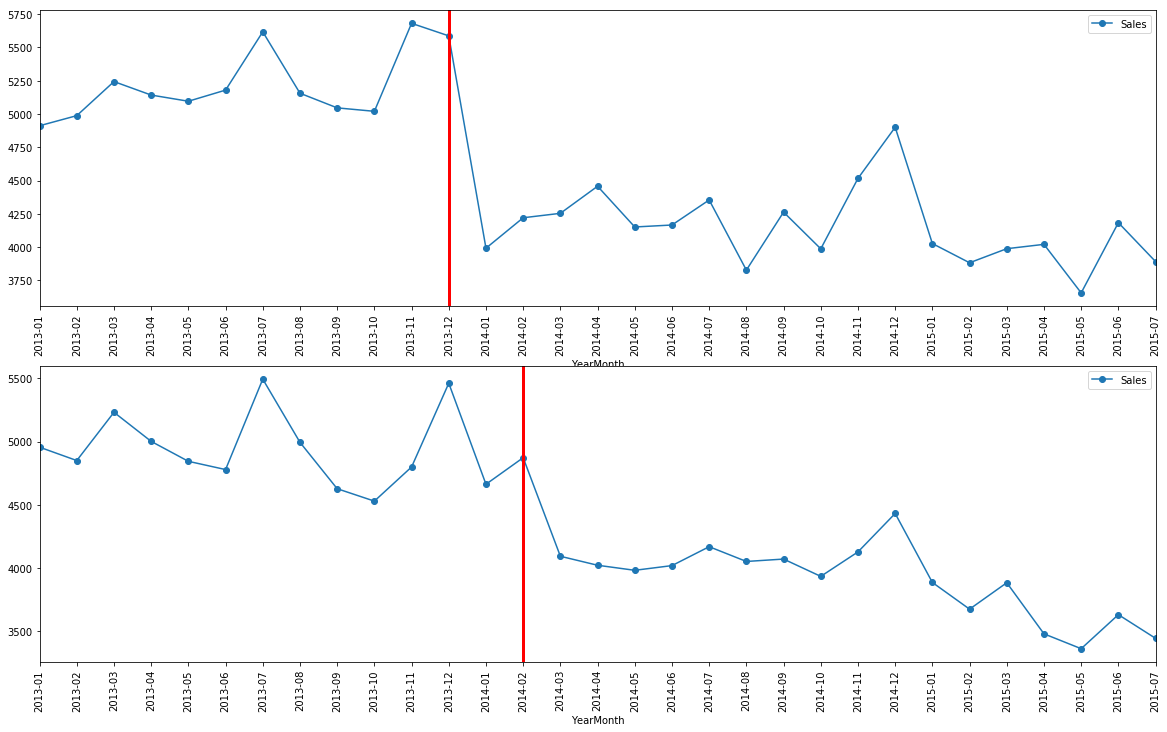

In [44]:
# Plot average Sales over time and highligth the time when Competition started
store_ids = [6, 30]
fig, (axis1, axis2) = plt.subplots(2, 1, figsize=(20, 12))
axs = [axis1, axis2]
for (i, store_id) in enumerate(store_ids):
    store_data = train[train['Store'] == store_id]
    average_store_sales = store_data.groupby('YearMonth')['Sales'].mean()
    # get year and month when Competition started
    y = store_df['CompetitionOpenSinceYear'].loc[store_df['Store']  == store_id].values[0]
    m = store_df['CompetitionOpenSinceMonth'].loc[store_df['Store'] == store_id].values[0]
    # Plot 
    ax = average_store_sales.plot(legend=True, marker='o', ax=axs[i])
    axs[i].set_xticks(range(len(average_store_sales)))
    axs[i].set_xticklabels(average_store_sales.index.tolist(), rotation=90)
    axs[i].axvline(x=((y-2013)*12)+(m-1), linewidth=3, color='red')

### Merge store and train data

In [45]:
data_merged = train.merge(store, left_on='Store', right_on='Store', how='left')
data_merged.fillna(0, inplace=True)
data_merged['StoreType'] = data_merged['StoreType'].map({'a': 0, 'b': 3, 'c': 2, 'd': 1})
data_merged['Assortment'] = data_merged['Assortment'].map({'a': 0, 'b': 2, 'c': 1})
data_merged['PromoInterval'] = data_merged['PromoInterval'].map({0: 0, '0': 0, 'Jan,Apr,Jul,Oct': 1, 
                                                                 'Feb,May,Aug,Nov': 2, 'Mar,Jun,Sept,Dec': 3})
data_merged.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,YearMonth,...,WeekOfYear,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,2015-07,...,31,2,0,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,2015-07,...,31,0,0,570.0,11.0,2007.0,1,13.0,2010.0,1
2,3,5,2015-07-31,8314,821,1,1,0,1,2015-07,...,31,0,0,14130.0,12.0,2006.0,1,14.0,2011.0,1


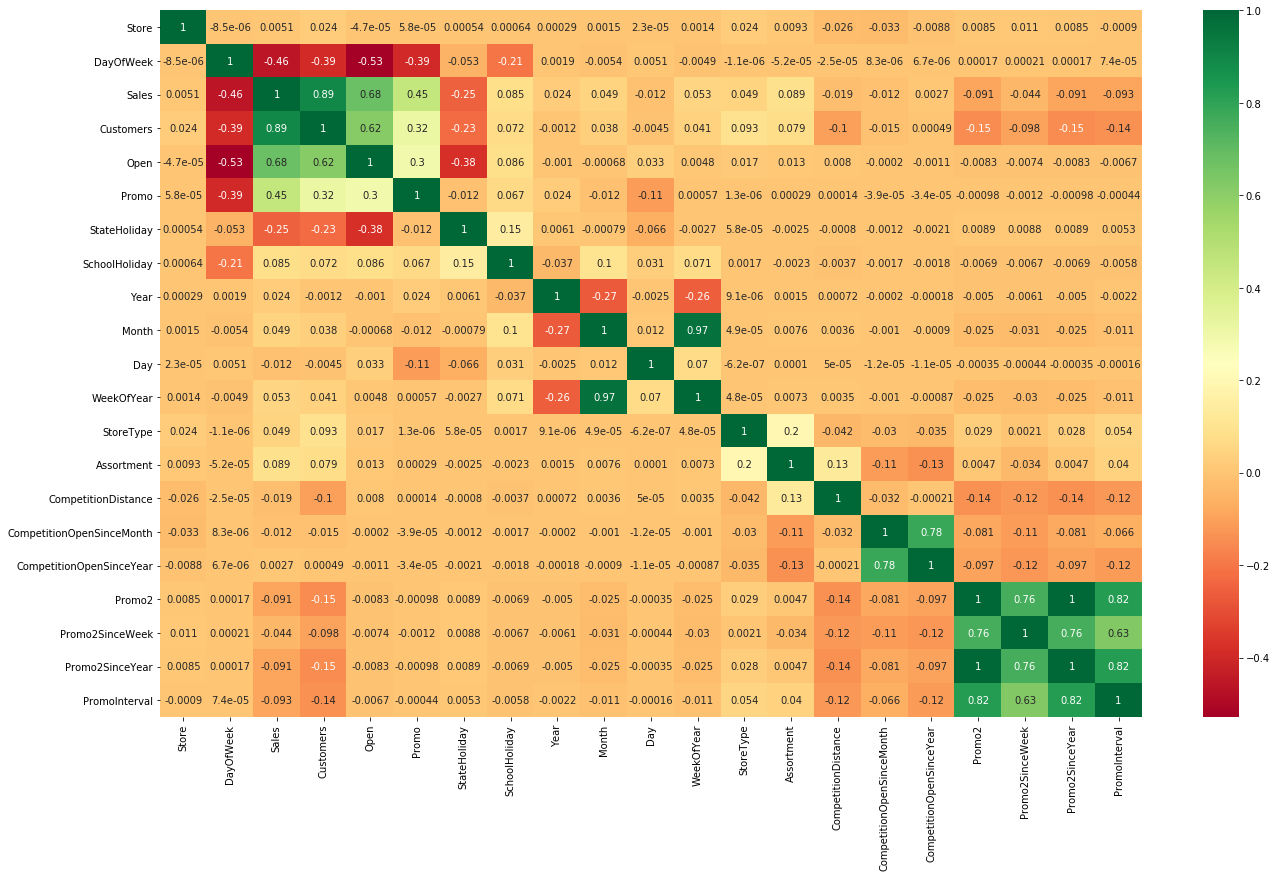

In [46]:
# Correlations
plt.figure(figsize=(22, 13))
sns.heatmap(data_merged.corr(), annot=True, cmap="RdYlGn")

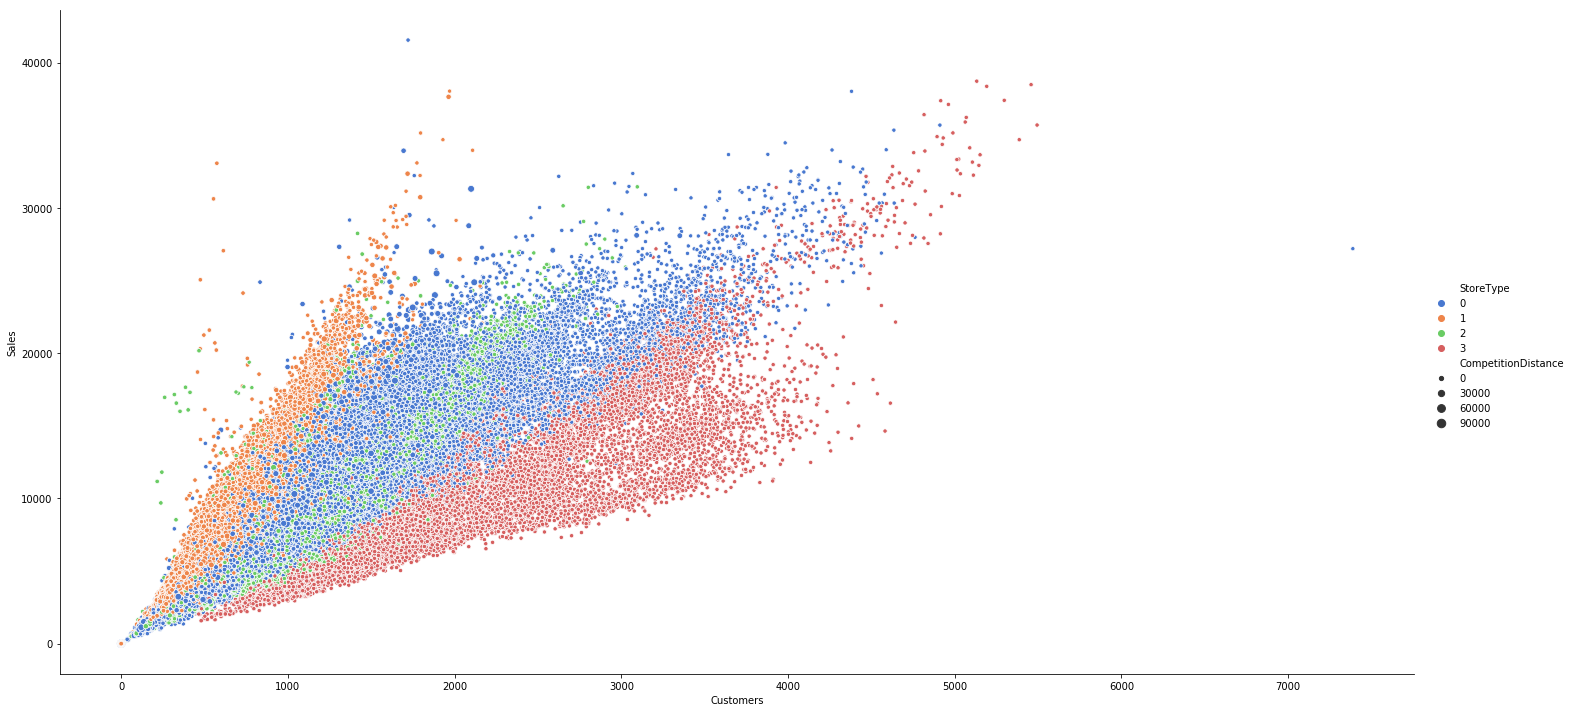

In [47]:
# Plot influence of the store type and number of customers
sns.relplot(x='Customers', y='Sales', hue='StoreType', size='CompetitionDistance',
            palette='muted', height=10, aspect=2, data=data_merged)

The type of store directly affects the number of customers and the sales. Stores of type 1 tends to have less customers but more sales, whereas stores of type 3 has the opposite behavior.

# Models

We aim to predict store sales for any day of the year with sufficient performance based on the characteristics of the day. Care must be taken with the legitimacy of the variables used because each variable used for prediction must be known for the predicted day, otherwise the model cannot be used in prediction. Thus, we must leave aside the `Customers` feature.

The first idea we could have is to predict the sales as a historical median of a given store, day of week, and promo.

## Historical Medians

### Load datasets

In [48]:
store = pd.read_csv(data_path + 'store.csv')
train = pd.read_csv(data_path + 'train.csv', low_memory=False)
test = pd.read_csv(data_path + 'test.csv')

### Preprocessing

In [49]:
# use only Sales bigger then zero
train = train[train['Sales'] > 0]
# consider only open stores for training
train = train[train['Open'] != 0]
# features
features = ['Store', 'DayOfWeek', 'Promo']

### Split data between train and validation sets
Let us use the last six weeks of data of the train set.

In [50]:
train['Date'] = pd.to_datetime(train['Date'], format='%Y-%m-%d')
six_weeks_ago = train.Date.sort_values(ascending=False).reset_index(drop=True)[0] - dt.timedelta(weeks=6)
# split data
X_train = train[train['Date'] < six_weeks_ago]
X_valid = train[train['Date'] >= six_weeks_ago]

### Medians

In [51]:
historical_medians = X_train.groupby(features)['Sales'].median()
historical_medians = historical_medians.reset_index()
historical_medians = historical_medians.rename(columns={'Sales': 'Predicted_sales'})
historical_medians.head(3)

,Store,DayOfWeek,Promo,Predicted_sales
0,1,1,0,3994.0
1,1,1,1,5695.0
2,1,2,0,3794.0


Now, we can merge this table with the validation set to assign to each store a sales value depending on the day of week and if there is a current promo.

In [52]:
valid = pd.merge(X_valid, historical_medians, on=features, how='left')
valid.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Predicted_sales
0,1,5,2015-07-31,5263,555,1,1,0,1,5000.0
1,2,5,2015-07-31,6064,625,1,1,0,1,4930.5
2,3,5,2015-07-31,8314,821,1,1,0,1,7945.0


### Validate

What metric should we use to validate our results? 
A useful mnetric in regression is the Root Mean Square Error (RMSE): 

$$ \text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

It represents the sample standard deviation of the differences between predicted values and observed values (called residuals).

ANother netric we can use is the MAE

$$ \text{RMSE} = \frac{1}{n}\sum_{i=1}^n|y_i-\hat{y}_i|$$


It is the average of the absolute difference between the predicted values and observed value. The MAE is a linear score which means that all the individual differences are weighted equally in the average. For example, the difference between 10 and 0 will be twice the difference between 5 and 0. However, same is not true for RMSE.

It is easy to understand and interpret MAE because it directly takes the average of offsets whereas RMSE penalizes the higher difference more than MAE. Generally, RMSE will be higher than or equal to MAE. RMSE is usually the default metric of many models because loss function defined in terms of RMSE is smoothly differentiable and makes it easier to perform mathematical operations. One important distinction between MAE & RMSE is that minimizing the squared error over a set of numbers results in finding its mean and minimizing the absolute error results in finding its median. This is the reason why MAE is robust to outliers whereas RMSE is not.

Let us compute both metrics on the validation set:

In [53]:
rmse_error = rmse(valid.Sales.values, valid.Predicted_sales.values)
mae_error = mae(valid.Sales.values, valid.Predicted_sales.values)
print('RMSE: {:.6f}'.format(rmse_error))
print('MAE: {:.6f}'.format(mae_error))

RMSE: 1140.879986
MAE: 760.380121


## XGBoost model
To compare those results with a machine learning regression model, let us try a XGBoost model for regression. We will train a model minimizing the RMSE and compare the results.

### Global parameters

In [54]:
feature_map_path = results_path + 'XGBoost.fmap'
feature_importance_path = results_path + 'feature_importance.png'
params = {'objective': 'reg:linear',
          'booster' : 'gbtree',
          'subsample': 0.9,
          'eta': 0.3,
          'silent': 1,
          'seed': 42,
          'max_depth': 10,
          }
num_boost_round = 300

### Load datasets

In [55]:
store_data = pd.read_csv(data_path + 'store.csv')
train = pd.read_csv(data_path + 'train.csv', low_memory=False)
test = pd.read_csv(data_path + 'test.csv')

### Preprocessing

In [56]:
# use only Sales bigger then zero
train = train[train['Sales'] > 0]

In [57]:
train_set, features = preprocessing(train, store_data)

In [58]:
print('features: \n', features)
train_set[features].head(3)

features: 
 ['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday', 'StoreType', 'Assortment', 'StateHoliday', 'DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen']


,Store,CompetitionDistance,Promo,Promo2,SchoolHoliday,StoreType,Assortment,StateHoliday,DayOfWeek,Month,Day,Year,WeekOfYear,CompetitionOpen,PromoOpen
0,1,1270.0,1,0,1,2,0,0,5,7,31,2015,31,82.0,0.00
1,2,570.0,1,1,1,0,0,0,5,7,31,2015,31,92.0,64.50
2,3,14130.0,1,1,1,0,0,0,5,7,31,2015,31,103.0,52.25


### Split data between train and validation sets
Let us use the last six weeks of data of the train set.

In [59]:
X_train = train_set[train_set['Date'] < six_weeks_ago]
X_valid = train_set[train_set['Date'] >= six_weeks_ago]
y_train = X_train.Sales
y_valid = X_valid.Sales
xgb_train = xgb.DMatrix(X_train[features], y_train)
xgb_valid = xgb.DMatrix(X_valid[features], y_valid)

### Train with RMSE minimization

In [60]:
watchlist = [(xgb_train, 'train'), (xgb_valid, 'eval')]
gbm = xgb.train(params, xgb_train, num_boost_round, evals=watchlist,
                early_stopping_rounds=100, feval=rmse_XGBoost, verbose_eval=True)

[0]	train-rmse:5584.67	eval-rmse:5635.71	train-rmse:5584.67	eval-rmse:5635.71
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[1]	train-rmse:4229.2	eval-rmse:4294.2	train-rmse:4229.21	eval-rmse:4294.2
[2]	train-rmse:3364.88	eval-rmse:3431.58	train-rmse:3364.9	eval-rmse:3431.58
[3]	train-rmse:2829.97	eval-rmse:2899.69	train-rmse:2829.99	eval-rmse:2899.69
[4]	train-rmse:2508.5	eval-rmse:2555.67	train-rmse:2508.51	eval-rmse:2555.67
[5]	train-rmse:2291.27	eval-rmse:2345.38	train-rmse:2291.28	eval-rmse:2345.39
[6]	train-rmse:2130.04	eval-rmse:2203.56	train-rmse:2130.05	eval-rmse:2203.56
[7]	train-rmse:2048.28	eval-rmse:2136.79	train-rmse:2048.29	eval-rmse:2136.79
[8]	train-rmse:1914.29	eval-rmse:2001.84	train-rmse:1914.3	eval-rmse:2001.84
[9]	train-rmse:1867.06	eval-rmse:1964.22	train-rmse:1867.07	eval-rmse:1964.22
[10]	train-rmse:1789.78	eval-rmse:1898.96	train-rmse:1789.79	eval-rmse:1898.96
[11

[103]	train-rmse:673.059	eval-rmse:1087.76	train-rmse:673.063	eval-rmse:1087.76
[104]	train-rmse:670.665	eval-rmse:1089.35	train-rmse:670.669	eval-rmse:1089.35
[105]	train-rmse:668.466	eval-rmse:1088.02	train-rmse:668.47	eval-rmse:1088.02
[106]	train-rmse:667.244	eval-rmse:1087.52	train-rmse:667.248	eval-rmse:1087.52
[107]	train-rmse:665.832	eval-rmse:1087.22	train-rmse:665.836	eval-rmse:1087.22
[108]	train-rmse:663.687	eval-rmse:1086.14	train-rmse:663.691	eval-rmse:1086.14
[109]	train-rmse:661.963	eval-rmse:1086.25	train-rmse:661.966	eval-rmse:1086.25
[110]	train-rmse:660.084	eval-rmse:1087.14	train-rmse:660.088	eval-rmse:1087.14
[111]	train-rmse:658.886	eval-rmse:1086.95	train-rmse:658.89	eval-rmse:1086.95
[112]	train-rmse:657.656	eval-rmse:1086.95	train-rmse:657.66	eval-rmse:1086.95
[113]	train-rmse:656.765	eval-rmse:1086.54	train-rmse:656.768	eval-rmse:1086.54
[114]	train-rmse:653.618	eval-rmse:1084.81	train-rmse:653.622	eval-rmse:1084.81
[115]	train-rmse:651.799	eval-rmse:1083.96	

[207]	train-rmse:551.82	eval-rmse:1059.52	train-rmse:551.824	eval-rmse:1059.52
[208]	train-rmse:551.235	eval-rmse:1059.69	train-rmse:551.239	eval-rmse:1059.69
[209]	train-rmse:550.219	eval-rmse:1059.46	train-rmse:550.222	eval-rmse:1059.46
[210]	train-rmse:549.506	eval-rmse:1059.36	train-rmse:549.509	eval-rmse:1059.36
[211]	train-rmse:548.94	eval-rmse:1059.24	train-rmse:548.943	eval-rmse:1059.24
[212]	train-rmse:548.161	eval-rmse:1059.09	train-rmse:548.164	eval-rmse:1059.09
[213]	train-rmse:547.444	eval-rmse:1059.19	train-rmse:547.448	eval-rmse:1059.19
[214]	train-rmse:546.838	eval-rmse:1059.26	train-rmse:546.841	eval-rmse:1059.26
[215]	train-rmse:546.134	eval-rmse:1059.21	train-rmse:546.138	eval-rmse:1059.21
[216]	train-rmse:545.177	eval-rmse:1058.14	train-rmse:545.18	eval-rmse:1058.14
[217]	train-rmse:544.495	eval-rmse:1057.69	train-rmse:544.498	eval-rmse:1057.69
[218]	train-rmse:543.64	eval-rmse:1057.54	train-rmse:543.643	eval-rmse:1057.54
[219]	train-rmse:542.98	eval-rmse:1057.26	tr

### Validate

In [61]:
y_pred = gbm.predict(xgb.DMatrix(X_valid[features]))
rmse_error = rmse(X_valid.Sales.values, y_pred)
mae_error = mae(X_valid.Sales.values, y_pred)
print('RMSE: {:.6f}'.format(rmse_error))
print('MAE: {:.6f}'.format(mae_error))

RMSE: 1053.728584
MAE: 725.513799


In terms of RMSE and MAE, the XGBoost gives better results than when using historical means. This score means that the average of the absolute difference between the predicted sales and sales over the last 6 weeks is around 726.

## Choosing best model: XGBoost

In [62]:
valid = X_valid.copy()
valid['Predicted_sales'] = y_pred
valid = valid.sort_values(by='Date')

#### Sum of the Sales VS Sum of the Predicted Sales on the Validation set of all stores

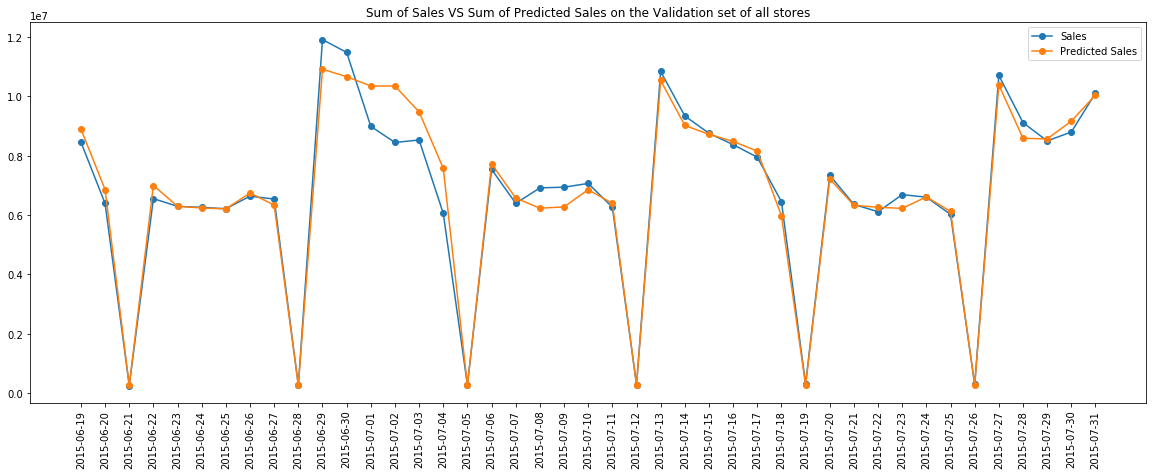

In [63]:
time_range = 60
valid_by_dates = valid.groupby('Date').sum()[['Sales', 'Predicted_sales']]
valid_by_dates = valid_by_dates.iloc[-time_range:,:]
# Plot
fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(range(len(valid_by_dates)), valid_by_dates.Sales, marker='o', label='Sales')
plt.plot(range(len(valid_by_dates)), valid_by_dates.Predicted_sales, marker='o', label='Predicted Sales')
ax.set_xticks(range(len(valid_by_dates)))
xlabels = ax.set_xticklabels([str(x)[:-9] for x in valid_by_dates.index.tolist()], rotation=90)
plt.title('Sum of Sales VS Sum of Predicted Sales on the Validation set of all stores')
plt.legend()
plt.savefig(results_path + 'valid_sum_sales.png')
plt.show()

#### Sales VS Predicted Sales on the Validation set for specific stores

RMSE: 849.802569
MAE: 652.279924


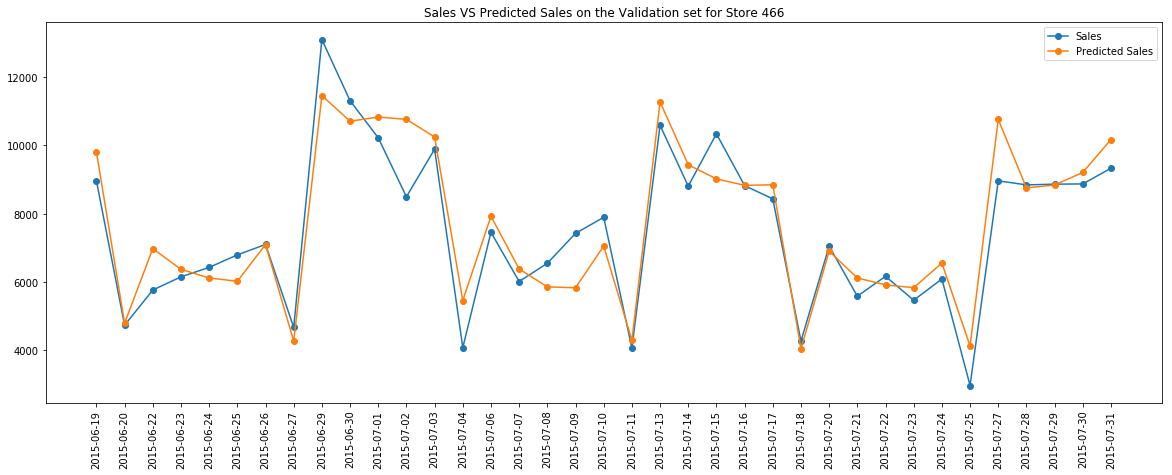

RMSE: 1123.447658
MAE: 909.051652


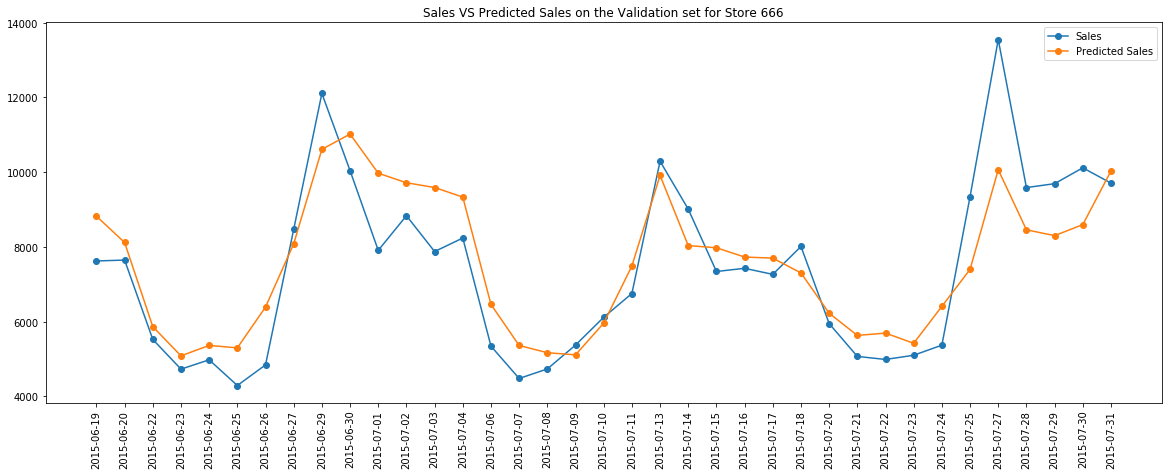

RMSE: 619.272384
MAE: 498.365802


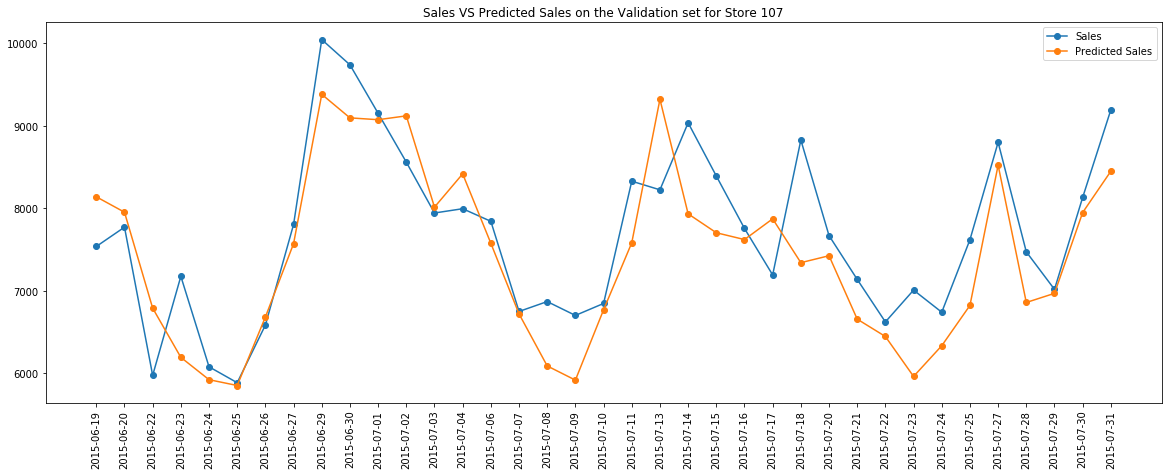

In [64]:
stores = [466, 666, 107]
for store in stores:
    store_df = valid[valid['Store'] == store]
    fig, ax = plt.subplots(figsize=(20, 7))
    rmse_error = rmse(store_df.Sales.values, store_df.Predicted_sales.values)
    mae_error = mae(store_df.Sales.values, store_df.Predicted_sales.values)
    print('RMSE: {:.6f}'.format(rmse_error))
    print('MAE: {:.6f}'.format(mae_error))
    plt.plot(range(len(store_df)), store_df.Sales, marker='o', label='Sales')
    plt.plot(range(len(store_df)), store_df.Predicted_sales, marker='o', label='Predicted Sales')
    ax.set_xticks(range(len(store_df)))
    xlabels = ax.set_xticklabels(store_df.Date.apply(lambda x: str(x)[:-9]).tolist(), rotation=90)
    plt.title('Sales VS Predicted Sales on the Validation set for Store ' + str(store))
    plt.legend()
    plt.savefig(results_path + 'valid_sales_store_' + str(store) + '.png')
    plt.show()

The high accuracy of the model obtained, and of the variables chosen, is evident. The seasonalities and variability of the model is very easily integrated, while taking into account that this is data that is not available for the model at the time of training.

### Prediction on the test set

In [65]:
# save ids of closed stores, because we will assign their sales value to 0
closed_store_ids = test.loc[test['Open'] == 0, 'Id'].values
test_set, _ = preprocessing(test, store_data)
# prediction
xbg_test = xgb.DMatrix(test_set[features])
test_pred = gbm.predict(xbg_test)

In [66]:
# append ids that were closed, and assign their sales value to 0
result = pd.DataFrame({'Id': test_set['Id'], 'Predicted_sales': test_pred})
result = result.append(pd.DataFrame(data=zip(closed_store_ids, [0]*len(closed_store_ids)), 
                                    columns=['Id', 'Predicted_sales']))
test_results = test.merge(result, left_on='Id', right_on='Id').sort_values(by='Date')
test_results.head(3)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Predicted_sales
41087,41088,1115,6,2015-08-01,1.0,0,0,1,9518.671875
40522,40523,378,6,2015-08-01,1.0,0,0,0,7832.257812
40521,40522,377,6,2015-08-01,1.0,0,0,0,7348.530273


#### Sum of the predicted sales on the test set for all stores

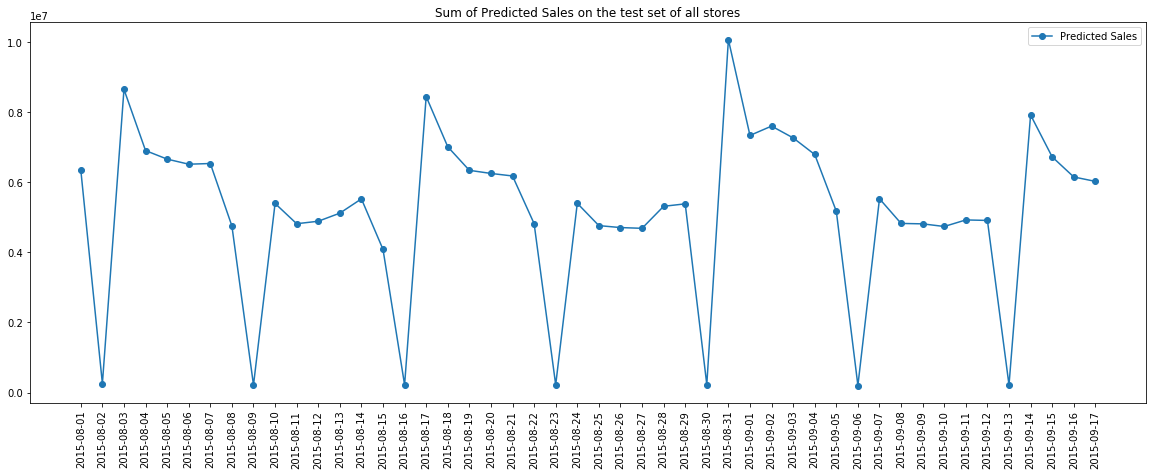

In [67]:
test_by_dates = test_results.groupby('Date').sum()[['Predicted_sales']]

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(range(len(test_by_dates)), test_by_dates.Predicted_sales, marker='o', label='Predicted Sales')
ax.set_xticks(range(len(test_by_dates)))
xlabels = ax.set_xticklabels([str(x)[:-9] for x in test_by_dates.index.tolist()], rotation=90)
plt.title('Sum of Predicted Sales on the test set of all stores')
plt.legend()
plt.savefig(results_path + 'test_sum_sales.png')
plt.show()

#### Predicted Sales on the test set for specific stores

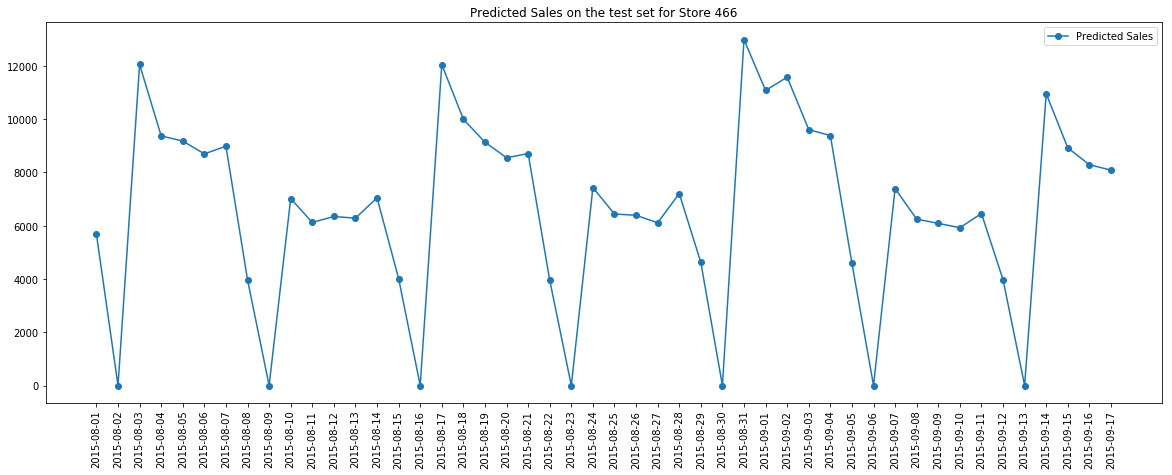

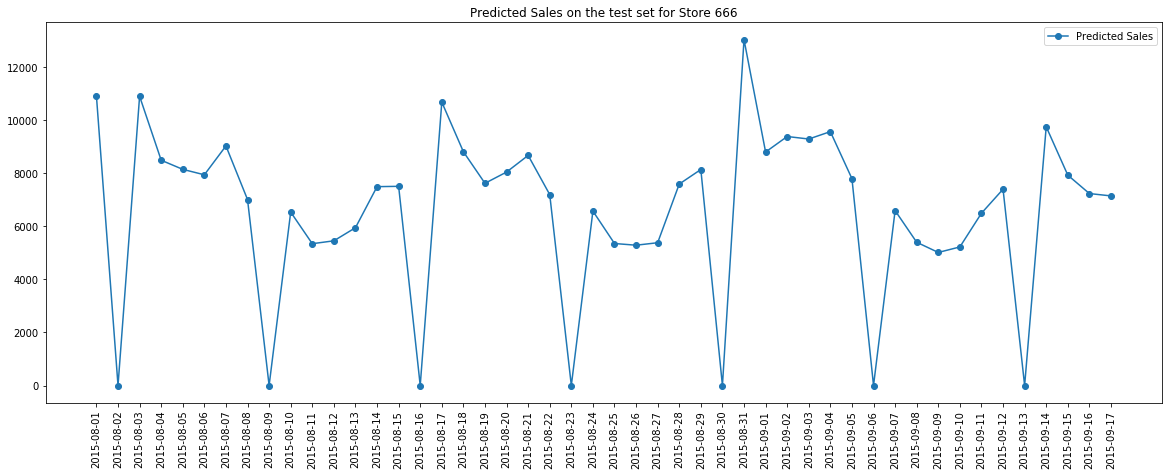

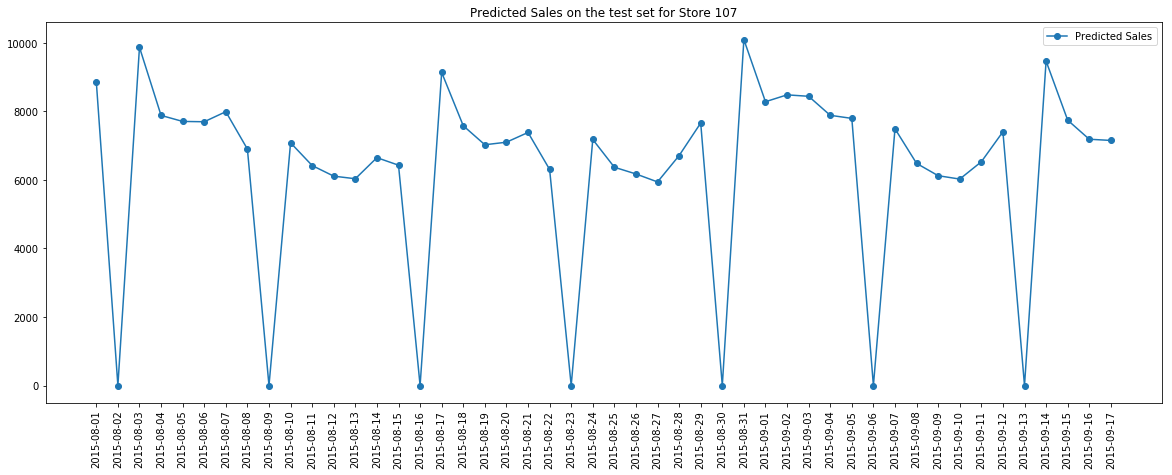

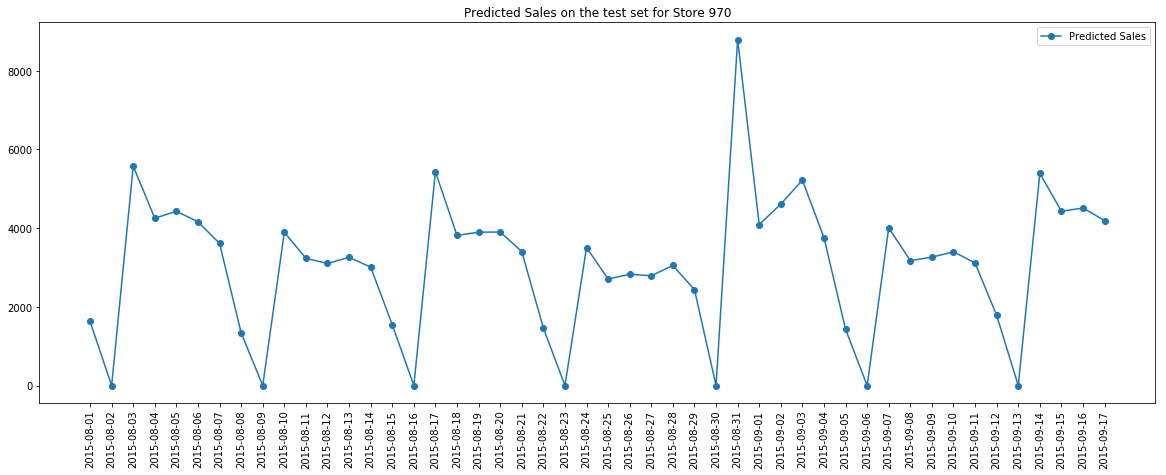

In [68]:
stores = [466, 666, 107, 970]
for store in stores:
    store_df = test_results[test_results['Store'] == store]
    fig, ax = plt.subplots(figsize=(20, 7))
    plt.plot(range(len(store_df)), store_df.Predicted_sales, marker='o', label='Predicted Sales')
    ax.set_xticks(range(len(store_df)))
    xlabels = ax.set_xticklabels(store_df.Date.apply(lambda x: str(x)[:-9]).tolist(), rotation=90)
    plt.title('Predicted Sales on the test set for Store ' + str(store))
    plt.legend()
    plt.savefig(results_path + 'test_sales_store_' + str(store) + '.png')
    plt.show()

### Feature Importance

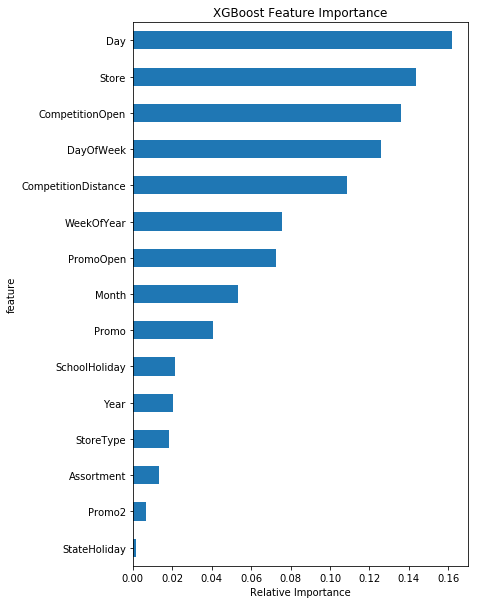

In [69]:
create_feature_map(features, feature_map_path)
importance = gbm.get_fscore(fmap=feature_map_path)
importance = sorted(importance.items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
fimp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('Relative Importance')
fig_fimp = fimp.get_figure()
fig_fimp.savefig(feature_importance_path, bbox_inches='tight', pad_inches=1)

We can see that the feature `Day` has the highest relative importance for the prediction. Store is the second best as we saw above that each store does not have the same amount of sales and customers. Therefore, the regression model should learn to discriminate across stores. We can observe the importance as well of the competition with `CompetitionOpen` and `CompetitionDistance`.

In fact, the sales of the Rossman stores depends mainly on the day of the month, the store, whether there is competition or a promo, and on the day of the week. Some of those conclusions were already observed in the analysis above, for instance, we know that on Monday, stores generate more sales than usual.